# Encoder-Decoder LSTM

In [1]:
import os

import numpy as np
import pandas as pd
import yfinance as yf
from finta import TA
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, Flatten, LSTM

os.chdir(os.path.dirname(os.getcwd()))

from main.utils.data import load_data

df_parsed = load_data()

In [2]:
n_out = 4
n_future = 7

Divide the dataset into standard weeks

In [3]:
df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

In [4]:
idx_end

Timestamp('2021-07-25 00:00:00', freq='-1D')

In [5]:
idx_start

Timestamp('2018-01-01 00:00:00', freq='D')

Considering data with four features: A, C, G, A_diff

In [6]:
df['A_diff'] = df['A'].diff()

daily_data = df.loc[idx_start: idx_end][['A', 'C', 'G', 'A_diff']]

In [7]:
scale = 100000

def split_dataset(data):
    
    # split into standard weeks
    train, test = data[7:-210], data[-210:]
    y_train, y_test = train[:, 0]/scale, test[:, 0]/scale
    
    # data normalization
    scaler = MinMaxScaler()
    train_norm = scaler.fit_transform(train)
    test_norm = scaler.transform(test)
    
    # restructure into windows of weekly data
    train_norm = np.array(np.split(train_norm, len(train_norm)/7))
    test_norm = np.array(np.split(test_norm, len(test_norm)/7))
    return train_norm, test_norm, y_train, y_test

train, test, label_train, label_test = split_dataset(daily_data.values)

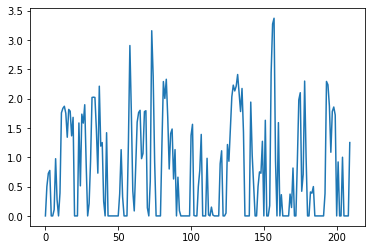

In [57]:
plt.plot(label_test)

In [8]:
# Simple guess:
# two weeks average -> 4 weeks after 7 weeks

In [52]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

y_train = np.copy(label_train)
y_test = np.copy(label_test)

idx = 0

predictions = []
ground_truth = []

while (idx+77) <= len(y_test):
    mean = np.mean(y_train[-365:]) * 7
    
    predictions += [mean] * 4
    
    target = np.array(np.split(y_test[idx+49: idx+77], 4)).sum(axis=1)
    
    ground_truth += list(target)
    
    y_train = np.append(y_train, y_test[idx: idx+7])
    
    idx += 7
    
    

In [53]:
mean_squared_log_error(ground_truth, predictions)

0.5258881394112751

In [54]:
mean_squared_error(ground_truth, predictions)

13.488642472102615

In [56]:
np.sqrt(np.exp(0.5))

1.2840254166877414

Encoder - Decoder LSTM Model

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-019-55320-6/MediaObjects/41598_2019_55320_Fig3_HTML.png?as=webp")

In [ ]:
def evaluate_forecasts(actual, predicted):
    
    msle = mean_squared_log_error(actual, np.clip(predicted, 0, 100))
    mse = mean_squared_error(actual, predicted)
    
    return msle, mse
            

def to_supervised(train, label_train, n_input, n_out=6, n_future=7):
    
    '''
    n_input: days
    n_out: measured in weeks
    n_future: measured in weeks
    '''
    
    # Multivariant input
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_start = in_end + 7 * n_future
        out_end = out_start + 7 * n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            # Univariant version
            '''
            x_input = data[in_start:in_end, 0]
             x_input = x_input.reshape((len(x_input), 1))
            '''
            X.append(data[in_start:in_end, :])
            y.append(np.array(np.split(label_train[out_start: out_end], n_out)).sum(axis=1))
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)


def build_model(train, train_label, n_input, n_out=6, n_future=7):
    # prepare data
    train_x, train_y = to_supervised(train, train_label, n_input, n_out=n_out, n_future=n_future) 
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    model.add(TimeDistributed(Dense(1)))  # one for univariant output
    model.compile(loss='msle', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n_feature] Multivariant input
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
                     
                     
def evaluation_model(train, test, label_train, label_test, n_input, n_out=6, n_future=7):
    
    model = build_model(train, label_train, n_input=n_input, n_out=n_out, n_future=n_future)
    history = [x for x in train]
    
    predictions = list()
    observations = list()
    
    for i in tqdm(range(len(test) - (n_out + n_future) + 1)): # because we want to predict up to 13 weeks <-- wtf...
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        observation = np.split(label_test[(i + n_future) * 7: (i + n_out + n_future) * 7], n_out)
        observations.append(np.array(observation).sum(axis=1))
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)[:, :, 0]
    observations = np.array(observations)
    
    return predictions, observations

In [ ]:
predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14,
                                             n_out=n_out, n_future=n_future)

In [ ]:
mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

### Take holiday into consideration

In [ ]:
import pandas as pd

known_holidays = [pd.Timestamp('2018-02-15'), pd.Timestamp('2018-02-16'), pd.Timestamp('2018-02-17'), pd.Timestamp('2018-02-18'),
                  pd.Timestamp('2018-12-30'), pd.Timestamp('2018-12-31'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-02'),
                  pd.Timestamp('2019-02-03'), pd.Timestamp('2019-02-04'), pd.Timestamp('2019-02-05'), pd.Timestamp('2019-02-06'),
                  pd.Timestamp('2019-02-07'), pd.Timestamp('2019-02-08'), pd.Timestamp('2019-02-09'), pd.Timestamp('2019-02-10'),
                  pd.Timestamp('2019-12-30'), pd.Timestamp('2019-12-31'), pd.Timestamp('2020-01-23'), pd.Timestamp('2020-01-24'),
                  pd.Timestamp('2020-01-25'), pd.Timestamp('2020-01-26'), pd.Timestamp('2020-01-27'), pd.Timestamp('2021-01-01'),
                  pd.Timestamp('2021-02-11'), pd.Timestamp('2021-02-12'), pd.Timestamp('2021-02-13'), pd.Timestamp('2021-02-14'),
                  pd.Timestamp('2019-04-05'), pd.Timestamp('2019-04-06'), pd.Timestamp('2019-04-07')]

In [ ]:
df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

In [ ]:
df['off'] = df.index.isin(known_holidays).astype(int)
df['off_shift'] = df['off'].shift(-56)  # 讓數據看見放假

df['A_diff'] = df['A'].diff()

daily_data = df.loc[idx_start: idx_end][['A', 'C', 'G', 'A_diff', 'off_shift']]

train, test, label_train, label_test = split_dataset(daily_data.values)

In [ ]:
predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

In [ ]:
mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

### Take holiday into consideration

外部數據 台灣塑膠工業 1301

In [ ]:
def load_stock_data(code: int):
    
    # yahoo finance 下載股票
    
    data = yf.Ticker(f'{code}.TW')

    df = data.history(start='2017-01-01', end='2021-07-31')
    
    return df

In [ ]:
df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

df['off'] = df.index.isin(known_holidays).astype(int)
df['off_shift'] = df['off'].shift(-7*(n_out + n_future))  # 讓數據看見放假
df['A_diff'] = df['A'].diff()
df['A_ewm_std'] = df['A'].ewm(span=14).std()

df_formosa = load_stock_data(1301)

df_formosa_macd = TA.MACD(df_formosa).rename(columns={'MACD': "FORMOSA_MACD", 'SIGNAL': "FORMOSA_SIGNAL"})
df_formosa_vbm = TA.VBM(df_formosa).to_frame().rename(columns={'VBM': "FORMOSA_VBM"})
df_formosa_ewm = TA.EVWMA(df_formosa, period=5).to_frame().rename(columns={'5 period EVWMA.': 'FORMOSA_EVWMA'})

df = df.join([df_formosa_macd, df_formosa_vbm, df_formosa_ewm]).fillna(method='bfill')

columns = ['A', 'C', 'G', 'A_diff', 'FORMOSA_SIGNAL', 'A_ewm_std', 'off_shift']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

### Take holiday into consideration

外部數據:
* 台灣塑膠工業 1301
* 榮運        2607 

In [ ]:
def stock_feature(code):
    
    df = load_stock_data(code)
    df_macd = TA.MACD(df).rename(columns={'MACD': f"{code}_MACD", 'SIGNAL': f"{code}_SIGNAL"})
    df_vbm = TA.VBM(df).to_frame().rename(columns={'VBM': f"{code}_VBM"})
    df_ewm = TA.EVWMA(df, period=5).to_frame().rename(columns={'5 period EVWMA.': f'{code}_EVWMA'})
    
    return pd.concat([df_macd, df_vbm, df_ewm], axis=1).fillna(method='bfill')

In [ ]:
df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

df['off'] = df.index.isin(known_holidays).astype(int)
df['off_shift'] = df['off'].shift(-7*(n_out + n_future))  # 讓數據看見放假
df['A_diff'] = df['A'].diff()
df['A_ewm_std'] = df['A'].ewm(span=14).std()

df_1301 = stock_feature(1301)
df_2607 = stock_feature(2607)

df = df.join([df_1301, df_2607]).fillna(method='bfill')

columns = ['A', 'C', 'G', 'A_diff', '1301_SIGNAL', 'A_ewm_std', 'off_shift']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

In [ ]:
columns = ['A', 'C', 'G', 'A_diff', '1301_SIGNAL', 'A_ewm_std', 'off_shift', '2607_SIGNAL']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

### Fusion COVID19 data

In [ ]:
covid19 = pd.read_csv('data/owid-covid-data.csv')

In [ ]:
covid19_USA = covid19[covid19['iso_code']=='USA']

In [ ]:
covid19_USA['date'].iloc[0]

In [ ]:
date = [pd.Timestamp(covid19_USA['date'].iloc[i]) for i in range(len(covid19_USA))]

columns = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'icu_patients',
           'hosp_patients']

data = covid19_USA[columns].values

df_covid_USA = pd.DataFrame(data=data, columns=columns, index=date)

df_covid_USA['week_day'] = [idx.weekday() for idx in df_covid_USA.index]
df_covid_USA['new_cases_7_sum'] = df_covid_USA['new_cases'].rolling(7, min_periods=1).sum()
df_covid_USA['new_deaths_7_sum'] = df_covid_USA['new_deaths'].rolling(7, min_periods=1).sum()

for idx, row in df_covid_USA.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df_covid_USA.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break
        
df_covid_USA = df_covid_USA.loc[idx_start: idx_end]

In [ ]:
# Load manufacturer data

df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

df['off'] = df.index.isin(known_holidays).astype(int)
df['off_shift'] = df['off'].shift(-7*(n_out + n_future))  # 讓數據看見放假
df['A_diff'] = df['A'].diff()
df['A_ewm_std'] = df['A'].ewm(span=14).std()

columns = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'icu_patients',
           'hosp_patients', 'new_cases_7_sum', 'new_deaths_7_sum']

df = df.join([df_covid_USA[columns]]).fillna(0)

In [ ]:
df.head(10)

In [ ]:
df_1301 = stock_feature(1301)
# df_2607 = stock_feature(2607)

df = df.join([df_1301]).fillna(method='bfill')

columns = ['A', 'C', 'G', 'A_diff', '1301_SIGNAL', 'A_ewm_std', 'off_shift',
           'new_cases_smoothed', 'new_deaths_smoothed', 'new_cases_7_sum']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

In [ ]:
df_1301 = stock_feature(1301)
df_1304= stock_feature(1304)

# df = df.join([df_1301, df_1304]).fillna(method='bfill')

columns = ['A', 'C', 'G', 'A_diff', '1301_SIGNAL', 'A_ewm_std', 'off_shift',
           'new_cases_smoothed', 'new_deaths_smoothed']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")

### Take Taiwan into consideration

In [ ]:
def covid_country(df, iso_code):
    
    covid19 = df[df['iso_code']==iso_code]
    
    date = [pd.Timestamp(covid19['date'].iloc[i]) for i in range(len(covid19))]

    columns = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'icu_patients',
               'hosp_patients']

    data = covid19[columns].values
    
    columns = [f'{iso_code}_{c}' for c in columns]
    
    df_covid = pd.DataFrame(data=data, columns=columns, index=date)

    df_covid['week_day'] = [idx.weekday() for idx in df_covid.index]
    df_covid[f'{iso_code}_new_cases_7_sum'] = df_covid[f'{iso_code}_new_cases'].rolling(7, min_periods=1).sum()
    df_covid[f'{iso_code}_new_deaths_7_sum'] = df_covid[f'{iso_code}_new_deaths'].rolling(7, min_periods=1).sum()
    df_covid[f'{iso_code}_new_cases_3_sum'] = df_covid[f'{iso_code}_new_cases'].rolling(3, min_periods=1).sum()
    df_covid[f'{iso_code}_new_deaths_3_sum'] = df_covid[f'{iso_code}_new_deaths'].rolling(3, min_periods=1).sum()
    
    for idx, row in df_covid.iterrows():
        if row['week_day'] == 0:
            idx_start = idx
            break

    for idx, row in df_covid.iloc[::-1].iterrows():
        if row['week_day'] == 6:
            idx_end = idx
            break

    df_covid = df_covid.loc[idx_start: idx_end]
    
    df_covid.drop(labels=['week_day'], axis=1, inplace=True)
    
    return df_covid.fillna(0)

In [ ]:
df_TW = covid_country(covid19, "TWN")

In [ ]:
df_US = covid_country(covid19, "USA")

In [ ]:
df = df_parsed.copy()
df = df.resample('1D').sum()
df.fillna(0, inplace=True)

df['week_day'] = [idx.weekday() for idx in df.index]

for idx, row in df.iterrows():
    if row['week_day'] == 0:
        idx_start = idx
        break
        
for idx, row in df.iloc[::-1].iterrows():
    if row['week_day'] == 6:
        idx_end = idx
        break

df['off'] = df.index.isin(known_holidays).astype(int)
df['off_shift'] = df['off'].shift(-7*(n_out + n_future))  # 讓數據看見放假
df['A_diff'] = df['A'].diff()
df['A_ewm_std'] = df['A'].ewm(span=14).std()

df = df.join([df_US, df_TW]).fillna(0)

In [ ]:
df.columns

In [ ]:
df_1301 = stock_feature(1301)
# df_2607 = stock_feature(2607)

df = df.join([df_1301]).fillna(method='bfill')

columns = ['A', 'C', 'G', 'A_diff', '1301_SIGNAL', 'A_ewm_std', 'off_shift',
           'USA_new_cases_smoothed', 'USA_new_deaths_smoothed', 'TWN_new_cases_smoothed',
           'TWN_new_deaths_smoothed']

daily_data = df.loc[idx_start: idx_end][columns]

train, test, label_train, label_test = split_dataset(daily_data.values)

predictions, observations = evaluation_model(train, test, label_train, label_test, n_input=14, n_out=n_out, n_future=n_future)

mlse, mse = evaluate_forecasts(observations, predictions)

print(f"MLSE = {mlse}, MSE = {mse}")